In [1]:
import matplotlib.pyplot as plt
import pygpufit.gpufit as gf
import mat73
from os.path import dirname, join as pjoin
from scipy import signal
import numpy as np
# cuda available checks
print('CUDA available: {}'.format(gf.cuda_available()))
print('CUDA versions runtime: {}, driver: {}'.format(*gf.get_cuda_version()))

CUDA available: True
CUDA versions runtime: (11, 4), driver: (12, 1)


In [2]:
import sys
print(sys.path)

['C:\\Users\\cduPC\\anaconda3\\envs\\qudi\\lib\\site-packages\\git\\ext\\gitdb', 'C:\\Users\\cduPC\\Documents\\GitHub\\qudi\\config', '', 'C:\\Program Files\\Swabian Instruments\\Time Tagger\\driver\\python', 'C:\\Users\\cduPC\\anaconda3\\envs\\qudi\\python36.zip', 'C:\\Program Files\\Swabian Instruments\\Time Tagger\\driver\\x64\\python3.6', 'C:\\Users\\cduPC\\anaconda3\\envs\\qudi\\DLLs', 'C:\\Users\\cduPC\\anaconda3\\envs\\qudi\\lib', 'C:\\Users\\cduPC\\anaconda3\\envs\\qudi', 'C:\\Users\\cduPC\\anaconda3\\envs\\qudi\\lib\\site-packages', 'C:\\Users\\cduPC\\anaconda3\\envs\\qudi\\lib\\site-packages\\gitdb\\ext\\smmap', 'C:\\Users\\cduPC\\anaconda3\\envs\\qudi\\lib\\site-packages\\IPython\\extensions', '.', 'C:\\Users\\cduPC\\Documents\\GitHub\\qudi\\logic\\pulsed\\sampling_function_defs', 'C:\\Users\\cduPC\\Documents\\GitHub\\qudi\\logic\\pulsed\\predefined_generate_methods', 'C:\\Users\\cduPC\\Documents\\GitHub\\qudi\\logic\\fitmethods', 'C:\\Users\\cduPC\\Documents\\GitHub\\qudi\\

In [2]:
def initialize_parameters(data,center1=None,width1=None,Amp1=None,offset1=1):
    Amp1_array = np.min(data,axis=1)-np.max(data,axis=1)
          
    assert center1 is not None
    assert width1 is not None
    
    center1_array = center1 * np.ones(data.shape[0])
    width1_array = width1 * np.ones(data.shape[0])
    offset1_array = offset1 * np.ones(data.shape[0])
    
    return np.array(np.stack((Amp1_array,center1_array,width1_array,offset1_array),axis=1), dtype=np.float32)

In [3]:
def lorentz_1D(x, p):
    amp = p[0]
    center = p[1]
    width = p[2]
    offset= p[3]
    y = (amp * (width**2))/((x-center)**2 + (width)**2) + offset
    return y 

In [4]:
def gauss_1D(x, p):
    amp = p[0]
    center = p[1]
    width = p[2]
    offset= p[3]
    y = amp * (np.e ** (-(x-center)**2/(2*width**2))) + offset
    return y 

def linear(x, p):
    return p[0] + p[1]*x

In [3]:
data_dir = r"Z:\Montana_setup\samples and data\CrI3_NV\Flake#3_CrI3_twisted_3L+3L_Quinn\Pulsed_ESR\5K\40G_temp_test_v2\RawData"
mat_fname = pjoin(data_dir, "005_ESR.mat")
mat_data = mat73.loadmat(mat_fname)

In [4]:
mat_data['outputdata'].get('ave').get('mean').shape

(220, 220, 162)

In [10]:
widefieldmeasurementlogic.odmr_raw_data.shape

(140, 140, 111)

In [8]:
type(mat_data['outputdata'].get('ave').get('mean'))

<class 'numpy.ndarray'>

In [11]:
raw_data = np.array(mat_data['outputdata']['ave']['mean'])
frequency = np.array(mat_data['outputdata']['freq'], dtype=np.float32)

# Reshape data
data_normalized = raw_data/raw_data[:, :, 1, np.newaxis]

n_fits = raw_data.shape[0]*raw_data.shape[1]
number_points = raw_data.shape[2]
data = np.array(np.reshape(data_normalized, (n_fits, number_points)), dtype=np.float32)

In [13]:
raw_data.shape

(220, 220, 162)

In [14]:
type(raw_data)

<class 'numpy.ndarray'>

In [22]:
freqtest = widefieldmeasurementlogic.odmr_plot_x
freqtest*1e-9

array([2.76 , 2.762, 2.764, 2.766, 2.768, 2.77 , 2.772, 2.774, 2.776,
       2.778, 2.78 , 2.782, 2.784, 2.786, 2.788, 2.79 , 2.792, 2.794,
       2.796, 2.798, 2.8  , 2.802, 2.804, 2.806, 2.808, 2.81 , 2.812,
       2.814, 2.816, 2.818, 2.82 , 2.822, 2.824, 2.826, 2.828, 2.83 ,
       2.832, 2.834, 2.836, 2.838, 2.84 , 2.842, 2.844, 2.846, 2.848,
       2.85 , 2.852, 2.854, 2.856, 2.858, 2.86 , 2.862, 2.864, 2.866,
       2.868, 2.87 , 2.872, 2.874, 2.876, 2.878, 2.88 , 2.882, 2.884,
       2.886, 2.888, 2.89 , 2.892, 2.894, 2.896, 2.898, 2.9  , 2.902,
       2.904, 2.906, 2.908, 2.91 , 2.912, 2.914, 2.916, 2.918, 2.92 ,
       2.922, 2.924, 2.926, 2.928, 2.93 , 2.932, 2.934, 2.936, 2.938,
       2.94 , 2.942, 2.944, 2.946, 2.948, 2.95 , 2.952, 2.954, 2.956,
       2.958, 2.96 , 2.962, 2.964, 2.966, 2.968, 2.97 , 2.972, 2.974,
       2.976, 2.978, 2.98 ])

In [21]:
frequency

array([2.7   , 2.7015, 2.703 , 2.7045, 2.706 , 2.7075, 2.709 , 2.7105,
       2.712 , 2.7135, 2.715 , 2.7165, 2.718 , 2.7195, 2.721 , 2.7225,
       2.724 , 2.7255, 2.727 , 2.7285, 2.73  , 2.7315, 2.733 , 2.7345,
       2.736 , 2.7375, 2.739 , 2.7405, 2.742 , 2.7435, 2.745 , 2.7465,
       2.748 , 2.7495, 2.751 , 2.7525, 2.754 , 2.7555, 2.757 , 2.7585,
       2.76  , 2.7615, 2.763 , 2.7645, 2.766 , 2.7675, 2.769 , 2.7705,
       2.772 , 2.7735, 2.775 , 2.7765, 2.778 , 2.7795, 2.781 , 2.7825,
       2.784 , 2.7855, 2.787 , 2.7885, 2.79  , 2.7915, 2.793 , 2.7945,
       2.796 , 2.7975, 2.799 , 2.8005, 2.802 , 2.8035, 2.805 , 2.8065,
       2.808 , 2.8095, 2.811 , 2.8125, 2.814 , 2.8155, 2.817 , 2.8185,
       2.82  , 2.92  , 2.9215, 2.923 , 2.9245, 2.926 , 2.9275, 2.929 ,
       2.9305, 2.932 , 2.9335, 2.935 , 2.9365, 2.938 , 2.9395, 2.941 ,
       2.9425, 2.944 , 2.9455, 2.947 , 2.9485, 2.95  , 2.9515, 2.953 ,
       2.9545, 2.956 , 2.9575, 2.959 , 2.9605, 2.962 , 2.9635, 2.965 ,
      

In [18]:
type(frequency)

<class 'numpy.ndarray'>

In [ ]:
int(raw_data.shape[-1]/2)

In [7]:
# taking only one lorentzian and every other data point 
raw_data_test = raw_data[:, :, :int(raw_data.shape[-1]/2)-1:2]
frequency_test = frequency[:int(raw_data.shape[-1]/2)-1:2]
data_normalized_test = data_normalized[:, :, :int(raw_data.shape[-1]/2)-1:2]

n_fits_test = raw_data_test.shape[0]*raw_data_test.shape[1]
number_points_test = raw_data_test.shape[2]
data_test = np.array(np.reshape(data_normalized_test, (n_fits_test, number_points_test)), dtype=np.float32)

In [8]:
raw_data_test_upper = raw_data[:, :, int(raw_data.shape[-1]/2)::2]
frequency_test_upper = frequency[int(raw_data.shape[-1]/2)::2]
data_normalized_test_upper = data_normalized[:, :, int(raw_data.shape[-1]/2)::2]

n_fits_test_upper = raw_data_test_upper.shape[0]*raw_data_test_upper.shape[1]
number_points_test_upper = raw_data_test_upper.shape[2]
data_test_upper = np.array(np.reshape(data_normalized_test_upper, (n_fits_test_upper, number_points_test_upper)), dtype=np.float32)

In [ ]:
testing_f1

In [9]:
testing_f1 = np.arange(0,40)

In [10]:
# User Info
user_info = testing_f1

# tolerance
tolerance = 1e-9

# maximum number of iterations
max_number_iterations = 20

# Parameters to Fit
#parameters_to_fit = np.ones(7, dtype=np.float32)

estimator_id = 0

# model ID
# model_id = gf.ModelID.LORENTZ_1D
model_id = gf.ModelID.GAUSS_1D
# Initial parameters
number_fits = 0
initial_parameters = initialize_parameters(data_test,Amp1=None,center1=22,width1=10,offset1=1)
# initial_parameters = np.ones((number_fits, 2), dtype=np.float32)
# initial_parameters = np.array([[15,20,5,1]], dtype=np.float32)
initial_parameters.shape

initial_parameters_upper = initialize_parameters(data_test_upper,Amp1=None,center1=25,width1=10,offset1=1)

In [11]:
# run Gpufit   
parameters, states, chi_squares, number_iterations, execution_time = gf.fit(data_test, None, model_id, initial_parameters, tolerance, max_number_iterations, None, estimator_id, user_info=None)

parameters_upper, states_upper, chi_squares_upper, number_iterations_upper, execution_time_upper = gf.fit(data_test_upper, None, model_id, initial_parameters_upper, tolerance, max_number_iterations, None, estimator_id, user_info=None)

In [ ]:
parameters[3500]

In [ ]:
# n=0 to n=48399
n=22000

plt.plot(frequency_test,data_test[n,:],'.',c='blue')
plt.plot(frequency_test,lorentz_1D(testing_f1,parameters[n]),c='orange')
plt.show()

fcf = parameters[0][1]*0.003+2.7
print(f'fitted central frequency: {fcf}')

In [ ]:
# n=0 to n=48399
# n=21000

plt.plot(frequency_test_upper,data_test_upper[n,:],'.',c='blue')
plt.plot(frequency_test_upper,lorentz_1D(testing_f1_upper,parameters_upper[n]),c='orange')
plt.show()

fcf = parameters_upper[0][1]*0.003+2.92
print(f'fitted central frequency: {fcf}')

In [ ]:
execution_time

In [ ]:
execution_time_upper

In [ ]:
ratio = np.sum(states == 1) / parameters.shape[0] * 100
print(f'ratio max iterations exceeded  {ratio} %')

In [ ]:
final_data = parameters.reshape(raw_data_test.shape[0],raw_data_test.shape[1],4)
final_data_upper = parameters_upper.reshape(raw_data_test_upper.shape[0],raw_data_test_upper.shape[1],4)
X,Y = np.meshgrid(np.linspace(1,10,final_data.shape[0]),np.linspace(1,10,final_data.shape[1]))
fig, ax = plt.subplots()
pc = ax.pcolormesh(X,Y,((final_data_upper[:,:,1]*0.003+2.92)-(final_data[:,:,1]*0.003+2.7))/(2.8*2*10**(-3)),cmap='jet',vmin=39.7,vmax=41.7)
fig.colorbar(pc)
hello = ((final_data_upper[:,:,1]*0.003+2.92)-(final_data[:,:,1]*0.003+2.7))/(2.8*2*10**(-3))
print(hello)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right",size="5%", pad = 0.05)
# fig.colorbar(fig, cax=cax)

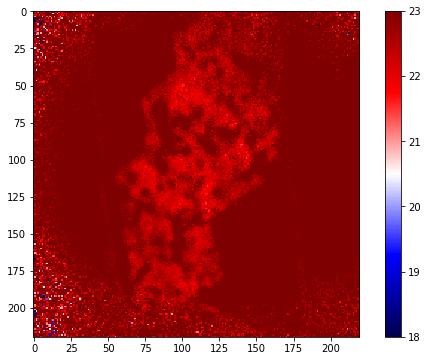

In [13]:
final_data = parameters.reshape(raw_data_test.shape[0],raw_data_test.shape[1],4)
final_data_upper = parameters_upper.reshape(raw_data_test_upper.shape[0],raw_data_test_upper.shape[1],4)
# X,Y = np.meshgrid(np.linspace(1,10,final_data.shape[0]),np.linspace(1,10,final_data.shape[1]))
# fig, ax = plt.subplots()
shw = plt.imshow((final_data_upper[:,:,1]-final_data[:,:,1]+40)*0.003/(2*2.8*10**(-3)),cmap='seismic',interpolation='none',vmin=18,vmax=23)
colorbar = plt.colorbar(shw)
plt.show()

In [ ]:
final_data = parameters.reshape(raw_data_test.shape[0],raw_data_test.shape[1],4)
final_data[4,1,:]

In [ ]:
final_data = parameters.reshape(raw_data_test.shape[0],raw_data_test.shape[1],4)
final_data_upper = parameters.reshape(raw_data_test_upper.shape[0],raw_data_test_upper.shape[1],4)
# X,Y = np.meshgrid(np.linspace(1,10,final_data.shape[0]),np.linspace(1,10,final_data.shape[1]))
# fig, ax = plt.subplots()
shw = plt.imshow((final_data_upper[:,:,1]-final_data[:,:,1]+40)*0.003/(2*2.8*10**(-3)),cmap='seismic',interpolation='none',vmin=18,vmax=23)
colorbar = plt.colorbar(shw)
plt.show()

In [ ]:
shw = plt.imshow((final_data_upper[:,:,1]-final_data[:,:,1]+40)*0.003/(2*2.8*10**(-3)),cmap='seismic',interpolation='none',vmin=21,vmax=25)
colorbar = plt.colorbar(shw)
plt.show()

In [ ]:
final_data_u pper[5,5]

In [ ]:
final_data[:,:,1].shape

In [ ]:
final_data[:,:,1]

In [ ]:
(final_data_upper[:,:,1]-final_data[:,:,1]+40)*0.003/(2*2.8*10**(-3))

In [ ]:
final_data_upper[:,:,1]-final_data[:,:,1]+40

In [ ]:
ratio = np.sum(states == 1) / parameters.shape[0] * 100
print(f'ratio max iterations exceeded  {ratio} %')
ratio_upper = np.sum(states == 1) / parameters_upper.shape[0] * 100
print(f'ratio_upper max iterations exceeded  {ratio_upper} %')